# 2017 Project 3(Investigate a Data set)

## Table of Contents
- [Introduction](#intro)
- [Questions](#questions)
- [Data Used](#reading)
- [Data Cleaning](#cleaning)
- [Data Analysis](#eda)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction
For this data analysis, I have chosen the data found on Gapminder.org [link](http://www.gapminder.org/data/). I would like to study the relationship between extreme poverty and some indicators like economic progress, health progress and other data. I would also like to investigate the changing face of poverty; how has it changed over the years globally and for different countries around the globe.

### Questions:

1. How does the GDP per capita vary with years for the above countries?
2. How does Extreme poverty vary with years for the above countries? Is it increasing or decreasing?
3. What about overall health of the country? I use the infant mortality and BMI (female/male) as the indicators for health of the country.
4. Study different periods in history : How was GDP affected during the war and post-war?

### Variables used for this study:
1. Cell Phone usage (cell_phone)
2. GDP per capita (Income) (gdp_per_capita), 
3. Mortality rate for under age 5 (under5mortality) 
4. Extreme Poverty (%age of population), i.e. people living at less than $1.25 per day (Poverty)
5. BMI's of males and females (BMI male, BMI female)

In [210]:
## import all necessary packages and functions.
import csv # read and write csv files
import pandas as pd
import numpy as np
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import numpy as np
import os
from scipy.optimize import curve_fit

<a id='reading'></a>
### Data Used- 

Read the Data files. The data files should be in a sub-directory called "data". It will read all the data files in that directory, hence it should not contain anything other than the data files.


I give here the names of the data files :

'cell_phone_per100.xlsx', 

'indicator gapminder gdp_per_capita_ppp.xlsx', 

'indicator gapminder under5mortality.xlsx', 

'Indicator_BMI female ASM.xlsx', 

'Indicator_BMI male ASM.xlsx', 

'Indicator_Poverty headcount ratio at $1.25 a day (PPP) (% of population).xlsx'

Read in the files. Then Rename the first column to a consistent value for all data sets. The first column is just the different countries so rename it to "Country".


In [211]:
"""
Read all the data files in this directory
"""
#Read the data
data_files=os.listdir('data')
     
data=[0]*len(data_files)      
for i in range(len(data_files)):
    data[i]=pd.read_excel('./data/'+data_files[i])
#Rename the first column name to 'Country' as otherwise the code finds it difficult to handle spaces and the names.
    data[i].rename(index=str,columns={data[i].columns[0]:"Country"},inplace=True)


<a id='look'></a>
### First Look at the data.
Print the list of data_files and choose some variables I would like to explore. I have chosen the following variables to look at as they are good indicators for the economy and health of the country. 

In [212]:
#First Look at the data
print(data_files)

#Choose some variables to explore. Use the same names as in the data file to retrieve indices
nvar=6
var=['cell_phone',"gdp_per_capita","under5mortality","Poverty","BMI male","BMI female"]

#Get the indices of the dataframes corresponding to these variables. This piece of code is needed
#as then you don't have to keep track of the order in which you put your variables.
ind=[0,0,0,0,0,0]
i=0

for v in var:
    for s in data_files:
        if v in str(s):
            ind[i]=data_files.index(s)
            i+=1
print(ind)

#Print a few lines of the data
data[ind[0]].head(5)



['cell_phone_per100.xlsx', 'GDPpercapitaconstant2000US.xlsx', 'indicator gapminder gdp_per_capita_ppp.xlsx', 'indicator gapminder under5mortality.xlsx', 'indicator gdp_total_ppp.xlsx', 'indicator wdi urbanpopulation.xlsx', 'Indicator_BMI female ASM.xlsx', 'Indicator_BMI male ASM.xlsx', 'Indicator_Poverty headcount ratio at $1.25 a day (PPP) (% of population).xlsx', 'indicator_t 15-64 labour to pop percent.xlsx', 'indicator_t 25-54 unemploy.xlsx', 'RTI age adjusted indicator LIVE.xlsx']
[0, 2, 3, 8, 7, 6]


,Country,1965,1966,1967,1968,1969,1970,1971,1972,1973,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
0,Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,0.101462,0.778857,2.247739,4.345509,8.867979,16.016337,26.470880,34.338687,41.385796,54.262080
2,Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,27.542432,35.407334,40.308673,48.705965,60.504364,73.270708,58.453315,77.167390,84.024138,96.393395
4,Algeria,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,1.431990,4.533908,15.071017,41.538459,62.883274,81.290123,78.515888,93.647115,92.421261,98.987590


In [213]:
#Function to handle missing values. One can specify two methods. Either fill every NaN values
#with zero, or use the backfill and forward fill method to fill the missing values with the
#nearest non-zero values.
def fillnull(df,meth=0):
    if meth == 0 : 
        df.fillna(0,inplace=True) 
    else :
        df.fillna(method='bfill',inplace=True)
        df.fillna(method='ffill',inplace=True)
    return df

<a id='eda'></a>
## Data Cleaning - Clean and reshape the data
After getting the individual datasets, I did the following reshaping and cleaning of the data :
1. I merged the datasets for a subset of countries that I would like to look at further.
3. The data lists years as columns, and countries as rows. I reshaped the data so that countries are still columns, but I convert the years to columns using pandas.melt function. 
4. The indicators from the different files are columns in this merged data set.
5. Some of the Years are listed as integers and others as strings. I changed the years to integer for all the dataframes.  The rows in each dataframe correspond to the countries.
6. Missing Values : I drop NaN values for variables when I make the plots, as I did not wish to lose all the rows when I do a general dropna. For the Poverty data which has very few points I decided to use the "interpolate" function to fill in the NaN values. For others I simply drop them.


In [214]:
"""
Merge the different files and the indicators of interest into a single data set.

"""
#Make a list of countries I am interested to look at further. I take a mix of third world and first world countries
#Define a list of colors which would be used by the trend lines for each country
clist = ["China","India","Brazil","United States","United Kingdom","Germany","Japan"]
cols = ['b','r','y','g','pink','indigo','gray','cyan']
_col=cols

#Loop over the indicators
#Choose a subset of the datasets (Use only some countries as defined in clist) and make
# an array of datasets called data for each indicator - ind is the array of indicators
for i in range(len(ind)):
    data1=data[ind[i]]
    df = data1[data1.Country.isin(clist)]
    nrow=len(df.index)   
    #Make the index sequential
    df.index = list(range(nrow))        
    data1=df

#Convert all year columns to type integer
    newcols = data1.columns[1:].astype('int')
    newcols = newcols.insert(0,data1.columns[0])
    data1.columns = newcols
    data[ind[i]] = data1

#Make a new dataframe transforming the years into columns using pandas melt -- newdf
newdf = pd.melt(data[ind[0]], id_vars=["Country"],var_name="Year", value_name=var[0])
# reset the indices as we selected only a few countries
newdf = newdf.sort_values(['Country','Year']).reset_index(drop=True)

#Now merge with the rest of the data files
for i in range(len(ind)-1):
    df2 = pd.melt(data[ind[i+1]], id_vars=["Country"],var_name="Year", value_name=var[i+1])
    df2 = df2.sort_values(['Country','Year']).reset_index(drop=True)
    
    nrow1=len(newdf)
    nrow2=len(df2.index)
    if nrow2>nrow1:
        newdf = df2.merge(newdf,on=['Country','Year'],how='left')
    else:
        newdf = newdf.merge(df2,on=['Country','Year'],how='left')
        
#Look at the merged Data set - NaN values are left as it is and taken care of later        
newdf.head(20)

,Country,Year,gdp_per_capita,cell_phone,under5mortality,Poverty,BMI male,BMI female
0,Brazil,1800,1109.0,NaN,417.44,NaN,NaN,NaN
1,Brazil,1801,1109.0,NaN,417.44,NaN,NaN,NaN
2,Brazil,1802,1109.0,NaN,417.44,NaN,NaN,NaN
3,Brazil,1803,1109.0,NaN,417.44,NaN,NaN,NaN
4,Brazil,1804,1109.0,NaN,417.44,NaN,NaN,NaN
5,Brazil,1805,1110.0,NaN,417.44,NaN,NaN,NaN
6,Brazil,1806,1110.0,NaN,417.44,NaN,NaN,NaN
7,Brazil,1807,1110.0,NaN,417.44,NaN,NaN,NaN
8,Brazil,1808,1110.0,NaN,417.44,NaN,NaN,NaN
9,Brazil,1809,1110.0,NaN,417.44,NaN,NaN,NaN


Notice that some columns have NaN's. I take care of them later, as if I do a general dropna(), it would remove all rows associated with the NaN's. Hence I drop them when I need to plot them later. 

<a id='eda'></a>
### Data Analysis
I define several functions to analyse the data and plot variables here. Some of the functions to do some basic plots are coded here. More functions are used for detailed analysis which I describe later.
<a id='plotting'></a>


We need to plot the data in various different ways. The next pieces of code define functions to plot histograms, trendlines and scatter plots.
- **func**: A polynomial function used in fits
- **plt_scatter**: Do a scatter plot of two given variables.
- **plt_trends**: Make a trend line of a given variable
- **plt_hist**: Make a histogram for the given variable

<a id='trends'></a>
#### Plotting trends for some variables.
We choose a mix of third-world and first-world nations and take a basic look at some the variables of interest. 

For Infant Mortality Rate and Poverty we just use third-world countries because the other countries have considerably lower levels. We can look at this further when we look at some statistics for these variables.

In [215]:
#A Polynomial fitting function
def func(x,*p):
    a=p[0]
    b=p[1]
    c=p[2]
    d=p[3]
    
    return a + b*x + c*x*x + d*x*x*x

In [1]:
def plt_trends(df,yrs,cname,var,labels,dofit=False,legpos='upper center') :
    """
    This function plots the given data df.
    cname corresponds to the country Name.
    labels - The names for x and y axes.
    legpos - The position of the legend. 
    dofit - Fits the trend line using linear regression. Default is false. Set to True if you want to fit.
    """

    nrow=len(cname)

    fitfunc = lambda p, x: p[0]+p[1]*x+p[2]*x*x+p[3]*x*x*x # Target function    
    errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
    
    for i in range(nrow):
        data=df[(df.Country==cname[i]) & (df.Year > yrs[0]) & (df.Year < yrs[1])]
        xdata=df['Year']
        ydata=df[var]
        xdata=xdata.values
        xdata=xdata.astype(float)
        ydata=ydata.values
        ydata=ydata.astype(float)
        plt.scatter(xdata,ydata,color=_col[i],label=cname[i],s=20)
        if dofit:
            init_vals = [1, 0, 1,1]
            popt, pcov = curve_fit(func, xdata, ydata, p0=init_vals)
            plt.plot(xdata, func(xdata, *popt), 'r-')

    plt.legend(loc=legpos)
    ylab=labels[0]
    xlab=labels[1]
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.title(ylab+" vs "+xlab)

In [217]:
# the histogram of the data
def plt_hist(data,index,bins,colnames,labels,legpos='upper center') :
    #Choose the columms you want to plot from and to. 
    k1=df.columns.get_loc(colnames[0])
    k2=df.columns.get_loc(colnames[1])   
    
    ydata=df.iloc[index,k1:k2]
    n, bins, patches = plt.hist(ydata,bins, normed=0, facecolor='g', alpha=0.75)
    plt.xlabel(labels)
    plt.ylabel("Frequency")
    plt.show()

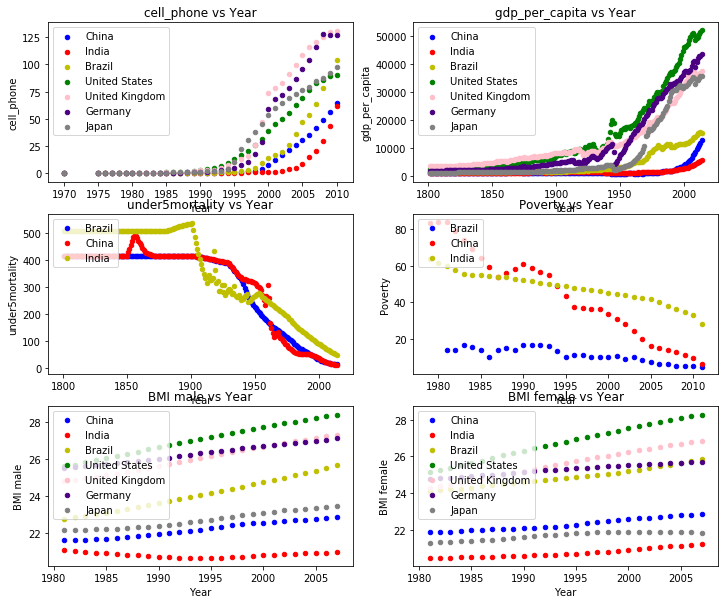

In [218]:
"""
Make Scatter Plots
"""

fig = plt.figure(figsize=(12,10))
sublist=['Brazil','China','India']
#subplot Index
plind=321
for i in range(nvar):
    j=plind+i
    plt.subplot(j)

#Get the minimum and maximum years
#drop all rows with Nan values for this particular variable of interest
    yrs=[0,0]
    labels=[var[i],"Year"]

    # For Extreme Poverty/Child Mortality use only the third-world countries
    if ( (i==2) | (i==3) ):
        df = newdf[(newdf.Country.isin(sublist))]
#Get the minimum and maximum years after dropping NaN values, otherwise it would list the years
#which have NaN values too
        temp = df[['Country','Year',var[i]]].dropna()
        yrs[0]=temp['Year'].min()
        yrs[1]=temp['Year'].max()   
#Interpolate to fill the NaN values    
        df = df[['Country','Year',var[i]]]    
        df=df.interpolate().dropna()        
        plt_trends(df,yrs,sublist,var[i],labels,False,'upper left')
    else :   
        df = newdf[['Country','Year',var[i]]].dropna()
        yrs[0]=df['Year'].min()
        yrs[1]=df['Year'].max()   
        plt_trends(df,yrs,clist,var[i],labels,False,'upper left')    
        
        
plt.show()

From the scatter plots one can infer the following:

1. We see that both GDP per capita and cell phone per person are clearly correlated as they should be. 
2. The GDP for every country has shown a gradual increase until the 1950 and then a marked steep increase after that time
3. Extreme poverties in the third world countries like Brazil, China, and India has gone down considerably.
4. Under 5 Infant mortality has also gone down considerably which is a wonderful thing to see.
5. A healthy BMI is between 18.5 and 24.9. All countries have heathy BMI's for male and females on an average but it is   interesting to see that BMI's have been increasing for almost all countries except perhaps Japan, and the richer nations seem to be becoming unhealthier with time as they have clearly exceeded the 25.0 BMI mark. India on the other hand, is on the lower end of the BMI which likely points to an under-nourished population.

### Comparing different variables - Correlation plots

Now we can look deeper between the relationships between the variables to see the correlations between the two.
### Some Questions :
1. How is extreme Poverty related to the overall economic growth (GDP per capita) of the nation?
2. How is the health situation of the country related to the GDP? We can plot the infant mortality rate (lower infant mortality rates show progress in medical services) vs GDP.
3. We can plot BMI vs GDP

In [219]:
def plt_compare(df,yrs,cnames,_var,dofit=False):
    """
    This function compares two indicators for a list of countries and plots them 
    together    
    df - Input data
    yrs - years
    var - Input variable names.
    cnames -  List of country Names
    dofit - Fit the trend line using linear regression. Default is false. Set to True if you want to fit.
    """

#Number of rows - Each row corresponds to a given country so multiple country trends are plotted. 
    nrow=len(cnames)
    yrslist=range(yrs[0],yrs[1],2)
#Loop over all the rows (Corresponds to countries) and plot them together
    for i in range(nrow):
        data=df[(df.Country==cnames[i]) & (df.Year > yrs[0]) & (df.Year < yrs[1])]
        #Set the Index column as the Year column and choose only some indices
#        data.set_index('Year')
        data = data[data.Year.isin(yrslist)]
        xdata=data[_var[1]]
        xdata=xdata.astype(float)
#        ydata=ydata.values
        ydata=data[_var[0]]
        ydata=ydata.astype(float)
        plt.scatter(xdata,ydata,color=_col[i],label=cnames[i],s=20)
        if dofit:
            init_vals = [60,-3,1,0]
            popt, pcov = curve_fit(func, xdata, ydata, p0=init_vals)
            plt.plot(xdata, func(xdata, *popt), 'r-')
            #Get Correlation coefficient 
        num = np.corrcoef(xdata, ydata)[0, 1]
        print("Correlation Coefficient",num)

#Do the plot        
    plt.legend()
    ylab=_var[0]
    xlab=_var[1]
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.title(ylab+" vs "+xlab)

['cell_phone', 'gdp_per_capita', 'under5mortality', 'Poverty', 'BMI male', 'BMI female']
Correlation Coefficient -0.908967847985
Correlation Coefficient -0.90325387255
Correlation Coefficient -0.973562868283
Correlation Coefficient -0.944866211994
Correlation Coefficient -0.554001179811
Correlation Coefficient -0.602834448955
Correlation Coefficient -0.985155685021
Correlation Coefficient -0.962999446031
Correlation Coefficient 0.236311762465


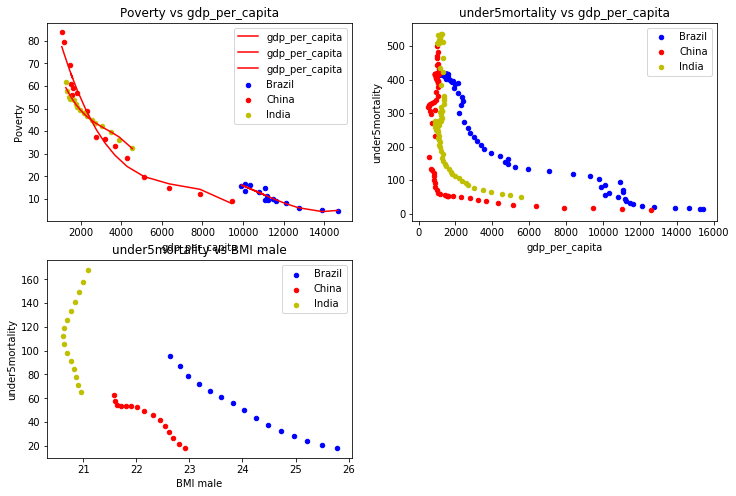

In [220]:
#Print the variables and choose two variables
fig = plt.figure(figsize=(12,8))
print(var)
# Choose Extreme Poverty vs GDP
labels=[var[3],var[1]]
#choose only some countries for this plot (Brazil, China, India)
#Since there is a lot of years missing in the case of Extreme Poverty we choose only some years
#to compare the two variables
sublist=['Brazil','China','India']
df = newdf[(newdf.Country.isin(sublist))]

plt.subplot(221)
#Just use one of the countries and get the minimum and maximum years
data=df[(df.Country==sublist[2])][['Year',var[3]]]
data.dropna(inplace=True)
yrs[0]=data['Year'].min(skipna=True)
yrs[1]=data['Year'].max(skipna=True)
df = df[['Country','Year',var[1],var[3]]]
df = df.interpolate().dropna()
plt_compare(df,yrs,sublist,labels,True)

plt.subplot(222)
#Choose Under5mortality vs GDP
labels=[var[2],var[1]]
#Just use one of the countries and get the minimum Poverty found.
data=newdf[(newdf.Country==sublist[2])][['Year',var[2]]]
data.dropna(inplace=True)

yrs[0]=data['Year'].min(skipna=True)
yrs[1]=data['Year'].max(skipna=True)
df = newdf[['Country','Year',var[1],var[2]]].dropna()
plt_compare(df,yrs,sublist,labels,False)

plt.subplot(223)
#Under5mortality vs BMI male
labels=[var[2],var[4]]
#Just use one of the countries and get the minimum Poverty found.
data=newdf[(newdf.Country==sublist[2])][['Year',var[2]]]
data.dropna(inplace=True)
yrs[0]=data['Year'].min(skipna=True)
yrs[1]=data['Year'].max(skipna=True)
df = newdf[['Country','Year',var[2],var[4]]].dropna()
plt_compare(df,yrs,sublist,labels,False)

plt.show()

#### Extreme Poverty vs GDP
The above plot shows that extreme poverty and GDP are correlated (Corr. coeff = -89.7%) and the Extreme Poverty rate falls as GDP increases. However, we cannot conclude based on this data alone, that one causes the other. As there maybe many other reasons because of which the extreme poverty rate is falling. It could be better education, better health programs, or better food distribution to remote areas in the country. 

I have fitted the Extreme Poverty data with a polynomial function and the fit shows very nicely that poverty rates have fallen steeply over the years as GDP has increased.

#### Infant Mortality vs GDP
As one can see that there is some correlation between the GDP and Infant mortality rate as the GDP goes beyond 2000(-87%) but below that it is uncorrelated except Brazil. We can tentatively infer that one of the factors for a growing GDP is better healthcare, and stronger population. So a lower infant mortality rate points to a higher GDP.

#### Infant Mortality vs BMI Male
One can see that there is some correlation between Infant mortality rates and average BMI's for China and Brazil once the infant mortality drops below 100, which shows that these indicators both point to a healthier nation.

### Statistical Analysis
1. Now we can look at some statistics for our data such as average BMI or average GDP, and so on over different periods. I divide  the period of time during world warI (1914:1918), During world war II(1940:1945). This is an example where we are using uneven bins. It would be particularly interesting to see how GDP was affected during these time periods.

   **Question** : How was GDP affected during the war and post-war?

I used the function binned_statistic to average over the bins. 
(Note : The data has to converted into type float before we can used it in the binned_statistic function.)

In [221]:
def get_stat(country,yrs,var):
    data=newdf[(newdf.Country==country) & (newdf.Year > yrs[0]) & (newdf.Year < yrs[1])][[var]]
    data.dropna()
    _mean = data[var].mean()
    _max = data[var].max()
    _min = data[var].min()
    return _mean, _max, _min
        
    

In [222]:
"""
Look at the mean, min and Maximum for certain periods for GDP and Poverty
"""
index=1
country='United States'

mybins=[1900,1914,1918,1940,1945,1970,1990,2015]

print("Stats.",var[index],"for "+country+":")

for i in range(len(mybins)-1):
    yrs=[mybins[i],mybins[i+1]]
    m = get_stat(country,yrs,var[index])    
    print('Period',yrs[0],'to',yrs[1],m)

country='India'
print("Stats.",var[index],"for "+country+":") 
for i in range(len(mybins)-1):
    yrs=[mybins[i],mybins[i+1]]
    m = get_stat(country,yrs,var[index])
    avg[i]=m[0]
    print('Period',yrs[0],'to',yrs[1],m)

index=3
country='United States'
mybins=[1970,1990,2015]

print("Stats.",var[index],"for "+country+":") 
for i in range(len(mybins)-1):
    yrs=[mybins[i],mybins[i+1]]
    m = get_stat(country,yrs,var[index])
    print('Period',yrs[0],'to',yrs[1],m)

country='India'
print("Stats.",var[index],"for "+country+":") 
for i in range(len(mybins)-1):
    yrs=[mybins[i],mybins[i+1]]
    m = get_stat(country,yrs,var[index])
    print('Period',yrs[0],'to',yrs[1],m)

Stats. gdp_per_capita for United States:
Period 1900 to 1914 (8046.692307692308, 8824.0, 7355.0)
Period 1914 to 1918 (8615.0, 9061.0, 8081.0)
Period 1918 to 1940 (9722.904761904761, 11272.0, 7769.0)
Period 1940 to 1945 (16834.75, 19847.0, 13239.0)
Period 1945 to 1970 (18171.041666666668, 24147.0, 14267.0)
Period 1970 to 1990 (29919.473684210527, 36830.0, 24350.0)
Period 1990 to 2015 (45743.041666666664, 52118.0, 36543.0)
Stats. gdp_per_capita for India:
Period 1900 to 1914 (1310.6153846153845, 1396.0, 1212.0)
Period 1914 to 1918 (1348.6666666666667, 1370.0, 1336.0)
Period 1918 to 1940 (1203.142857142857, 1309.0, 1069.0)
Period 1940 to 1945 (1062.75, 1079.0, 1043.0)
Period 1945 to 1970 (1000.9166666666666, 1141.0, 908.0)
Period 1970 to 1990 (1336.3157894736842, 1723.0, 1125.0)
Period 1990 to 2015 (3176.5833333333335, 5565.0, 1760.0)
Stats. Poverty for United States:
Period 1970 to 1990 (0.68, 0.68000000000000005, 0.68000000000000005)
Period 1990 to 2015 (1.0014285714285713, 1.6699999999

In [223]:
def plot_stat(x,y,type=0):
    # Get the average and standard deviation of a specified variable as specified by bins.
        bin_centers,_,_ = binned_statistic(x, x,statistic='max',bins=mybins)
        bin_averages,_,_ = binned_statistic(x, y,statistic='mean',bins=mybins)
        bin_stdevs,_,_  = binned_statistic(x, y,statistic='std',bins=mybins)
        
        if (type==0):
            plt.errorbar(bin_centers, bin_averages, bin_stdevs,fmt="o-", color=_col, label=cname)
            plt.legend(loc='best')
            plt.xlabel('Year')
            plt.ylabel(var[ind])
            plt.title('Average '+var[ind]+" vs "+'Year')    

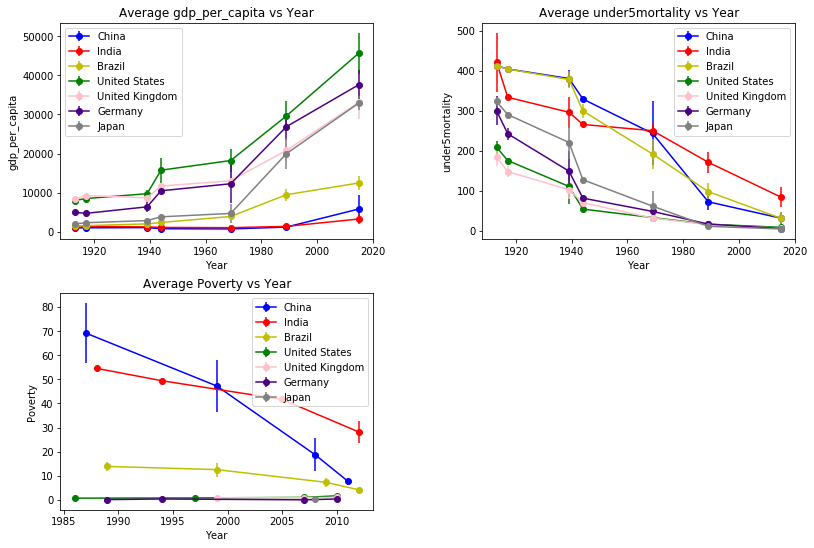

In [224]:
iplot=420
fig = plt.figure(figsize=(12,17))
for ind in range(1,len(var)-2):
    i = iplot+ind
    plt.subplot(i)
    mybins=[1900,1914,1918,1940,1945,1970,1990,2015]            
    for j in range(len(clist)):
        cname=clist[j]
        data=newdf[(newdf.Country==cname)][['Year',var[ind]]]
        data.dropna(inplace=True)
        x=data['Year'].values.astype(float)
        y=data[var[ind]].values.astype(float)
        _col=cols[j]
        if (ind!=3):
            plot_stat(x,y,0)
        else:
            #Poverty data isn't much- Starts from 1980 - Redfine bins
            mybins=[1980,1990,2000,2010,2015] 
            plot_stat(x,y,0)
            
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,wspace=0.35)
plt.show()


**GDP**:
From the above graphs, one can see that the GDP increased during "World War II" for some of the richer nations, and then there was a slump following the war. This is indicated by the slopes of the graphs, between 1940 and 1945. Following the war, Japan, Germany and United States have all shown tremendous growth and India and China are now emerging after 1990. 

Stats. gdp_per_capita for United States:
Period 1970 to 1990 29919
Period 1990 to 2015 45743
Growth = 53% 
Stats. gdp_per_capita for India:
Period 1970 to 1990 (1336)
Period 1990 to 2015 (3176)
Growth = 57% 

**Infant Mortality**: Infant Mortality is going down steadily which indicates improved health services in these countries. China showed a sudden jump in lowering its rate between 1970-1990.


**Extreme Poverty**: has been going down rapidly and China has by far done extremely well. Note the cross-over between India and China around 2000. India is rapidly lowering its extreme poverty rate between 1970 to 2015. Between 1970 to 2015, the average Infant Mortality went from 58.3 to 36.8 which is a drop of about 36%.


### How does Relative GDP change over the years for the different countries?
We can compare the relative GDP of the different countries compared to the economically strongest nation i.e. United States. I calculate the relative GDP and its error and then plot it in two different ways below. The bar graph is also a good way of noting the differences between these numbers for the different countries. I separate the first-world and the third-world nations for the bar plots.

In [229]:
def plot_stat_rel(x,y,type=0):
    # Get the average and standard deviation of a specified variable as specified by bins.
        bin_averages,_,_ = binned_statistic(x, y,statistic='mean',bins=mybins)
        bin_stdevs,_,_  = binned_statistic(x, y,statistic='std',bins=mybins)
 #Calculate ratio of GDP and its error
        rel_averages = bin_averages/bin_averages0
        err = bin_stdevs/bin_averages
        rel_std = (err*err+err0*err0)**(0.5)

        if (type==0):
            plt.errorbar(bin_centers, rel_averages, rel_std,fmt="o-", color=_col, label=cname)
            plt.legend(loc='best')
            plt.xlabel('Year')
            plt.ylabel(var[ind])
            plt.title('Relative Average '+var[ind]+" vs "+'Year')    
        else :    
            plt.bar(periods,rel_averages,width=0.5,color=_col, yerr=rel_std,alpha=0.5,label=cname)
            plt.legend(loc='best')
            plt.xlabel('Period')
            plt.ylabel(var[ind])
            plt.title('Relative Average '+var[ind]+" vs "+'Period')


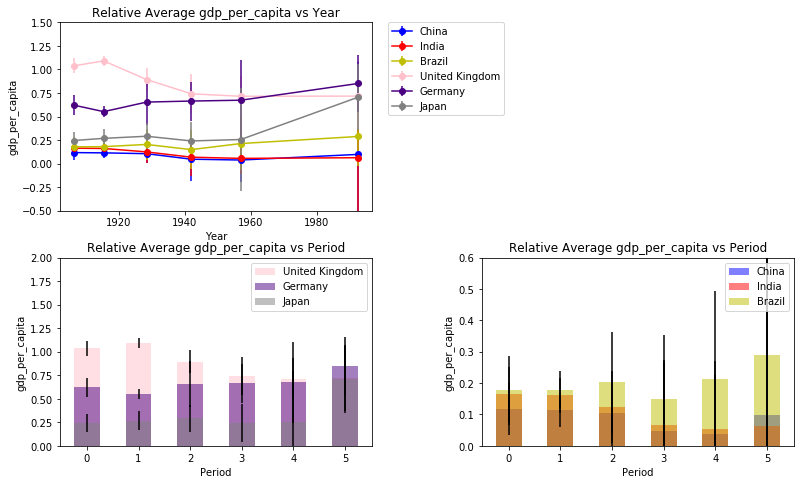

In [230]:
fig = plt.figure(figsize=(12,7))
ind=1
cname='United States'
data=newdf[(newdf.Country==cname)][['Year',var[ind]]]
data.dropna(inplace=True)
mybins=[1900,1914,1918,1940,1945,1970,2015]

x=data['Year'].values.astype(float)
y=data[var[ind]].values.astype(float)

#Get the stats for United States
bin_centers,_,_ = binned_statistic(x, x,statistic='mean',bins=mybins)
bin_averages0,_,_ = binned_statistic(x, y,statistic='mean',bins=mybins)
bin_stdevs0,_,_  = binned_statistic(x, y,statistic='std',bins=mybins)
err0 = bin_stdevs0/bin_averages0

# Trendline Plot
plt.subplot(221)
#Loop over the countries to get stats for the other countries
for j in range(len(clist)):
    cname=clist[j]
    if (cname!='United States') :
        data=newdf[(newdf.Country==cname)][['Year',var[ind]]]
        data.dropna(inplace=True)
        x=data['Year'].values.astype(float)
        y=data[var[ind]].values.astype(float)
        _col=cols[j]
        plot_stat_rel(x,y,0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(-0.5, 1.5)

#Bar Plot
plt.subplot(223)
periods = range(len(bin_centers))
sublist=clist[3:7]
for j in range(len(sublist)):
    cname=sublist[j]
    if (cname!='United States') :
        data=newdf[(newdf.Country==cname)][['Year',var[ind]]]
        data.dropna(inplace=True)
        x=data['Year'].values.astype(float)
        y=data[var[ind]].values.astype(float)
        _col=cols[j+3]
        plot_stat_rel(x,y,1)
plt.ylim(0.0, 2.0)

plt.subplot(224)
periods = range(len(bin_centers))
sublist=clist[0:3]
for j in range(len(sublist)):
    cname=sublist[j]
    if (cname!='United States') :
        data=newdf[(newdf.Country==cname)][['Year',var[ind]]]
        data.dropna(inplace=True)
        x=data['Year'].values.astype(float)
        y=data[var[ind]].values.astype(float)
        _col=cols[j]
        plot_stat_rel(x,y,1)
        
plt.ylim(0.0, 0.6)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,wspace=0.35)
plt.show()


### Relative GDP Results:
The relative average GDP with respect to United States has remained fairly constant for most countries
except Japan and Germany. As one can see, the slope after World was II for Japan and Germany are much
steeper. The value is about 75% for United Kingdom and Germany while about 25% for Japan between 1945 and 1970. But after 1970 Japan jumped to almost 73% and has caught up with United Kingdom.

United Kingdom has had a lower economic progress with respect to United States. India and China have been going down, while Brazil has been fairly constant.

<a id='conclusions'></a>
## Conclusions
To conclude, I have studied indicators for health and economic progress of different nations. 

We notice from the correlation plots between extreme poverty and GDP that there is a correlation (Corr. coeff = -89.7%) and the Extreme Poverty rate falls as GDP increases. However, there are limitations and we cannot conclude based on this data alone, what is the exact cause or which one causes the other. Does the GDP increase because more people are working harder or because more people have better facilities and hence GDP increases. We cannot answer this based on this data alone. There maybe many other reasons because of which the extreme poverty rate is falling. It could be better education, better health programs, or better food distribution to remote areas in the country. More analysis and time would be needed to understand what other factors can lower the extreme Poverty rate. Also, there is insufficient data of the extreme Poverty rate for the different countries in order to get a good understanding of the variation. Some of the impoverished areas are also ridden with crime, and other socio-economic problems which makes it difficult to gather accurate and sufficient data as well.

We find some correlation between the GDP and Infant mortality rate as the GDP goes higher, and we can tentatively infer that one of the factors for a growing GDP is better healthcare, and stronger population. So a lower infant mortality rate points to a higher GDP. However, more data and variables need to be included to study the increase in GDP. One needs a multivariate analysis and machine learning to conclude which factors influence the growth in GDP. One can also see that there is some correlation between Infant mortality rates and average BMI's for China and Brazil once the infant mortality drops below 100, which shows that these indicators both point to a healthier nation. 

We see some interesting features in the BMI. It seems to be steadily increasing with time and is higher for richer nations. But since we don't have the errors on the BMI values per year, one cannot say if they are significantly different from each other. However, we do see a trend, and it would be interesting to look into this further.

From the limited number of variables and the available data, we can make some inferences. All nations show a steady increase in their GDP and a lowering of Extreme Poverty and Infant Mortality rates which point towards a healthier nation. More data, variables and a multivariate analysis would be needed to find the path to a growth in economic progress. Thus, one could perhaps envision eradication of extreme Poverty in the next few decades, so that no one goes hungry and they have minimum facilties like electricity, water, and medical facilities in order to sustain life.  